In [ ]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image_1 = cv2.imread("/content/Driver Gosling.jpg")
image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)
image_1_gray = cv2.cvtColor(image_1,cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(image_1_gray)

image_2 = cv2.imread("/content/Pat Bateman.jpg")
image_2 = cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB)
image_2_gray = cv2.cvtColor(image_2,cv2.COLOR_BGR2GRAY)

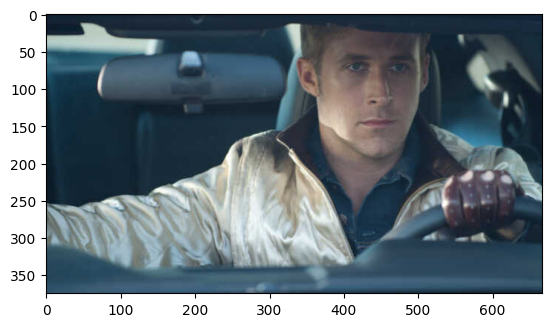

In [ ]:
plt.imshow(image_1)

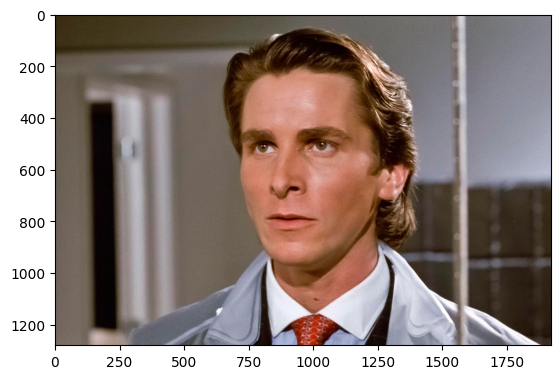

In [ ]:
plt.imshow(image_2)

In [ ]:
# Face Landmark Detector
!wget https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat

--2023-08-15 15:48:18--  https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat [following]
--2023-08-15 15:48:19--  https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M   248MB/s    in 0.4s    

2023-08-15 15:48:23 (248 M

In [ ]:
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

In [ ]:
height, width, channels = image_2.shape
image_2_new_face = np.zeros((height, width, channels), np.uint8)

In [ ]:
# Face 1
faces = detector(image_1_gray)
for face in faces:
    landmarks = predictor(image_1_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(image_1, image_1, mask=mask)

    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

In [ ]:
faces2 = detector(image_2_gray)
for face in faces2:
    landmarks = predictor(image_2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)

In [ ]:
lines_space_mask = np.zeros_like(image_1_gray)
lines_space_new_face = np.zeros_like(image_2)


for triangle_index in indexes_triangles:
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = image_1[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(image_1, image_1, mask=lines_space_mask)

    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    img2_new_face_rect_area = image_2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    image_2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

In [ ]:
img2_face_mask = np.zeros_like(image_2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


img2_head_noface = cv2.bitwise_and(image_2, image_2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, image_2_new_face)

(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, image_2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

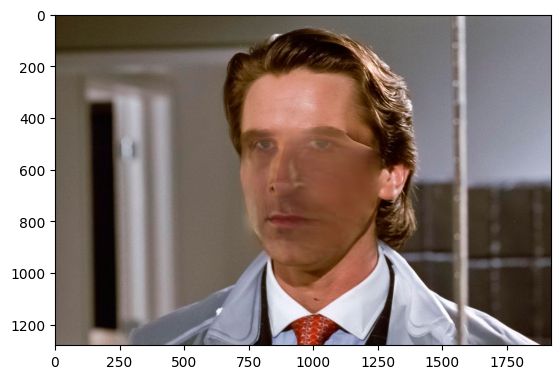

In [ ]:
plt.imshow(seamlessclone)